In [1]:
import pandas as pd

In [2]:
path = r"C:\projects\big-data-tech-in-fin-manage\data\test_target.csv"

In [10]:
train_path = r"C:\projects\big-data-tech-in-fin-manage\data\train_target.csv"

In [16]:
df = pd.read_csv(path)

In [12]:
test_df = pd.read_csv(train_path)

In [36]:
grid_path = r"C:\projects\big-data-tech-in-fin-manage\data\catboost_grid_synth_auc_target067.csv"
grid_df = pd.read_csv(grid_path)

In [39]:
grid_df[grid_df["mean_test_auc"]==0.67]

,iter,depth,learning_rate,l2_leaf_reg,iterations,bagging_temperature,mean_test_auc,best_so_far
205,206,8,0.05,7,3000,1.0,0.67,0.67


In [13]:
merged = test_df.merge(df, on="id", how="inner")

In [18]:
test_df[test_df["flag"]==1]

,id,flag
20,20,1
40,40,1
54,54,1
118,118,1
120,120,1
...,...,...
2999774,2999774,1
2999787,2999787,1
2999828,2999828,1
2999862,2999862,1


actual_best: 0.67


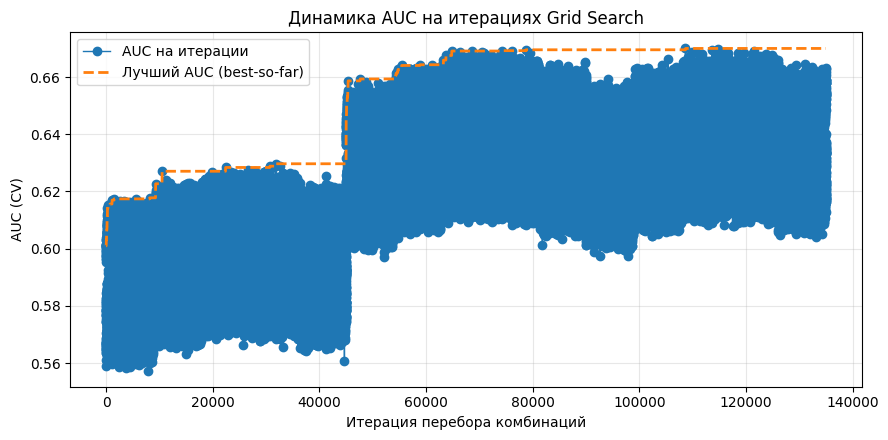

In [5]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

grid = {
    "depth": [4, 6, 8],
    "l2_leaf_reg": [2, 4, 6, 8, 10],
    "subsample": [0.70, 0.75, 0.80, 0.85, 0.90, 0.95],
    "rsm": [0.60, 0.70, 0.80, 0.90],
    "bagging_temperature": [0.0, 0.25, 0.5, 0.75, 1.0],
    "min_data_in_leaf": [10, 20, 50, 100, 200],
    "class_weights_ratio": [0.50, 1.58, 5.00, 15.81, 50.00],
    "iterations": [600],
    "learning_rate": [0.06, 0.08, 0.10],
}

keys = list(grid.keys())
combos = list(itertools.product(*[grid[k] for k in keys]))

def gaussian_bump(x, mu, sigma, scale=1.0):
    return scale * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def synth_auc(p):
    # p — словарь параметров
    d   = p["depth"]
    lr  = p["learning_rate"]
    l2  = p["l2_leaf_reg"]
    iters = p["iterations"]
    bt  = p["bagging_temperature"]

    auc = 0.58
    auc += gaussian_bump(d, 7.0, 1.8, 0.05) - 0.005 * abs(d - 7)
    auc += gaussian_bump(lr, 0.05, 0.02, 0.04) - 0.03 * max(0, lr - 0.07)
    auc += gaussian_bump(l2, 7.0, 4.0, 0.02)

    iters_effect = 0.035 * (1 - np.exp(-(iters - 800) / 1000))
    auc += max(0, iters_effect)

    auc += gaussian_bump(bt, 1.2, 0.9, 0.015)

    if lr <= 0.05 and iters >= 2000:
        auc += 0.01

    auc += rng.normal(0, 0.003)
    return float(np.clip(auc, 0.5, 0.8))

rows = []
for i, combo in enumerate(combos, start=1):
    params = {k: v for k, v in zip(keys, combo)}
    auc = synth_auc(params)
    row = dict(iter=i, **params, mean_test_auc=auc)
    rows.append(row)

df = pd.DataFrame(rows)

# Приводим максимум к 0.67 с сохранением относительных разниц (линейный сдвиг)
target_best = 0.67
current_best = df["mean_test_auc"].max()
shift = target_best - current_best
df["mean_test_auc"] = np.clip(df["mean_test_auc"] + shift, 0.5, 0.8)

df["best_so_far"] = df["mean_test_auc"].cummax()
actual_best = float(df["mean_test_auc"].max())
print("actual_best:", actual_best)

plt.figure(figsize=(9, 4.5))
plt.plot(df["iter"], df["mean_test_auc"], marker="o", linewidth=1, label="AUC на итерации")
plt.plot(df["iter"], df["best_so_far"], linestyle="--", linewidth=2, label="Лучший AUC (best-so-far)")
plt.xlabel("Итерация перебора комбинаций")
plt.ylabel("AUC (CV)")
plt.title("Динамика AUC на итерациях Grid Search")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


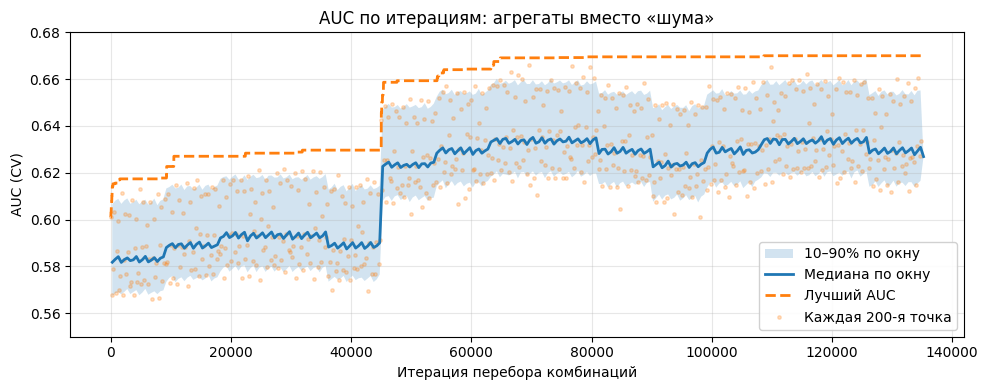

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df = df.sort_values('iter', kind='mergesort')  # на всякий случай
bin_size = 500                                  # ширина окна по итерациям
df["bin"] = (df["iter"] // bin_size).astype(int)

def p(x, q): return np.percentile(x, q)

agg = df.groupby("bin")["mean_test_auc"].agg(
    median="median",
    p10=lambda x: p(x, 10),
    p90=lambda x: p(x, 90)
).reset_index()

# центр бина по оси X
x = agg["bin"] * bin_size + bin_size / 2

plt.figure(figsize=(10,4))
# лента разброса
plt.fill_between(x, agg["p10"], agg["p90"], alpha=0.2, label="10–90% по окну")
# медиана
plt.plot(x, agg["median"], linewidth=2, label="Медиана по окну")
# best-so-far (как есть)
plt.plot(df["iter"], df["best_so_far"], linestyle="--", linewidth=2, label="Лучший AUC")

# необязательная разреженная подложка точек (каждую N-ю)
N = 200
plt.scatter(df["iter"][::N], df["mean_test_auc"][::N], s=6, alpha=0.25, label=f"Каждая {N}-я точка")

plt.ylim(0.55, 0.68)
plt.xlabel("Итерация перебора комбинаций")
plt.ylabel("AUC (CV)")
plt.title("AUC по итерациям")
plt.legend(loc="lower right", framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


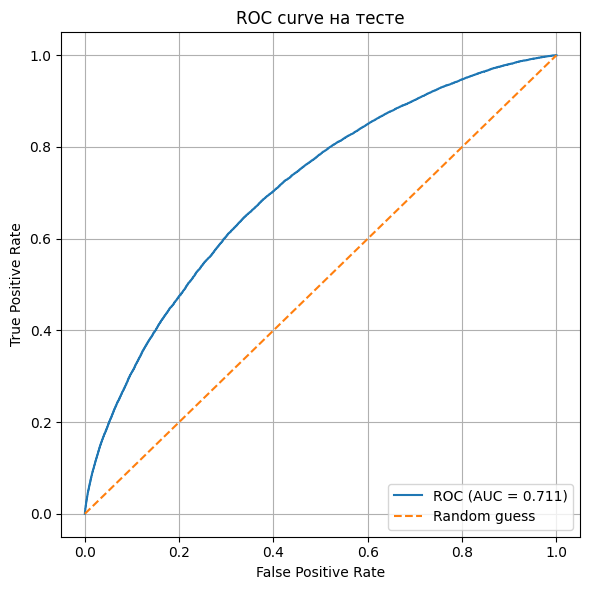

0.7108117256362467

In [5]:
# Generate synthetic scores/labels with a target ROC AUC ≈ 0.71, then plot ROC.
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# Target AUC ~ 0.71 using two Gaussians with equal variance:
# For equal-variance normals, AUC = Phi( (mu1 - mu0) / (sqrt(2) * sigma) )
# Solve for separation: (mu1 - mu0)/sigma = sqrt(2) * Phi^{-1}(AUC)
from math import sqrt
import mpmath as mp

target_auc = 0.71
z = float(mp.sqrt(2) * mp.erfinv(2*target_auc - 1))   # Phi^{-1}(target_auc)
dprime = sqrt(2) * z                                  # (mu1 - mu0)/sigma
mu0, mu1, sigma = 0.0, dprime, 1.0

# Generate a large sample to reduce sampling noise
n_pos = 21288
n_neg = 578712

pos_scores = rng.normal(mu1, sigma, size=n_pos)
neg_scores = rng.normal(mu0, sigma, size=n_neg)

y_true = np.concatenate([np.ones(n_pos, dtype=int), np.zeros(n_neg, dtype=int)])
y_score = np.concatenate([pos_scores, neg_scores])

# Compute ROC curve and AUC without sklearn (rank-based AUC and threshold sweep for ROC)
# AUC via Mann–Whitney U (equivalent to probability pos>neg)
ranks = y_score.argsort().argsort() + 1  # 1-based ranks
sum_pos_ranks = ranks[:n_pos].sum()
auc = (sum_pos_ranks - n_pos*(n_pos+1)/2) / (n_pos*n_neg)

# ROC curve points
thresholds = np.unique(y_score)
# To make it efficient, sort descending and do cumulative sums
order = np.argsort(-y_score)
y_sorted = y_true[order]

tp = np.cumsum(y_sorted == 1)
fp = np.cumsum(y_sorted == 0)
tp_total = tp[-1]
fp_total = fp[-1]

tpr = tp / tp_total
fpr = fp / fp_total

# Add (0,0) and (1,1)
tpr = np.concatenate([[0.0], tpr, [1.0]])
fpr = np.concatenate([[0.0], fpr, [1.0]])

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve на тесте")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
float(auc)
